# <center> Лабораторная работа №1</center>

In [1]:
import graphblas as gb

gb.init("suitesparse", blocking=False)

from graphblas import Matrix, dtypes, unary, binary, monoid, semiring, Recorder
from graphblas.io import mmread
import numpy as np
import os
from scipy.sparse import coo_matrix
import timeit
import matplotlib.pyplot as plt
import random

## 1) **наивный алгоритм** 

In [2]:
def naiveA3(A):
    '''Вычисление A^2'''
    A_squared = A.mxm(A)
    
    '''Вычисление A^3'''
    A_cube = A_squared.mxm(A)
    
    '''Выделение всех путей длины 3, где начало пути и конец пути совпадают (т.е. выделение диагонали матрицы)'''
    diag_elems = A_cube.diag()
    
    '''Находим След матрицы A^3 (сумму диагональных элементов) и сохраняем эту сумму или число 0, если треугольников нет и 
        приводим к типу int, т.к. число должно быть целое'''
    trace = int(diag_elems.reduce(gb.agg.sum).value or 0)
    
    '''
    Вычисляем число треугольников как trace / 6, т.к. каждый вариант был посчитан 6 раз: 
    (3 варианта начала вершины) * (2 варианта обхода треугольника (по часовой стрелке и против))
    '''
    ans = int(trace / 6)
    return ans

## 2) **наивный алгоритм с маской**

In [3]:
def naiveMaskA2(A):
    '''Вычисление A^2'''
    A_squared = A.mxm(A)
    
    '''Определение маски на основе матрицы смежности A (Ставятся значения True в ячейки, где были ребра в графе)'''
    mask = A.dup(dtype=dtypes.BOOL)

    '''
    Применение маски к матрице A^2 (таким образом, оставляются все пути длины 2 (из матрица A^2) 
    между вершинами, где еще есть путь длины 1 (условие маски)
    '''
    A_squared_masked = A_squared.dup(mask=mask)
    
    '''Суммирование всех элементов матрицы, если они есть, иначе возвращается 0'''
    sum_elems = int(A_squared_masked.reduce_scalar(gb.monoid.plus).value or 0)
    
    '''
    Вычисляем число треугольников как sum_elems / 6, т.к. каждый вариант был посчитан 6 раз: 
    (3 варианта начала вершины) * (2 варианта обхода треугольника (по часовой стрелке и против))
    '''
    ans = int(sum_elems / 6)
    return ans

## 3)**Сohen's algorithm**

In [4]:
def cohen(A):
    '''Поиск всех путей типа hi->lo (нижнетреугольная матрица от A)'''
    L = gb.select.tril(A)
    
    '''Поиск всех путей типа lo->hi (верхнетреугольная матрица от A)'''
    U = gb.select.triu(A)
    
    '''Создание маски для матрицы A'''
    mask = A.dup(dtype=dtypes.BOOL)
    
    '''
    Умножение L на U (поиск всех клиньев типа hi->lo->hi) и применение маски "mask" (закрытие клина ребром hi->hi)
    '''
    LU_masked = L.mxm(U).dup(mask=mask)
    
    '''Суммирование всех элементов матрицы, если они есть, иначе возвращается 0'''
    sum_elems = int(LU_masked.reduce_scalar(gb.monoid.plus).value or 0)
    
    # Поделим это число на 2 тк мы идентифицируем треугольники по min (lo) вершине 
    # а проход мы посчитали как hi1->lo->hi2 и hi1<-lo<-hi2 (то есть дважды)
    '''
    Вычисляем число треугольников как sum_elems / 2, т.к. каждый вариант был посчитан 2 раза (hi1->lo->hi2 и hi1<-lo<-hi2) 
    '''
    ans = int(sum_elems / 2)
    
    return ans

## 4)**Sandia algorithm**

In [5]:
def sandia(A):
    '''Поиск всех путей типа hi->lo (нижнетреугольная матрица от A)'''
    L = gb.select.tril(A)

    '''Создание маски для матрицы L'''
    mask = L.dup(dtype=dtypes.BOOL)
    
    '''Поиск путей вида max -> middle -> min и последующее применение маски "mask" (тем самым закрывается ребро max->min)'''
    LL_masked = L.mxm(L).dup(mask=mask)
    
    '''Суммирование всех элементов матрицы, если они есть, иначе возвращается 0'''
    ans = int(LL_masked.reduce_scalar(gb.monoid.plus).value or 0)
    
    return ans

## 5) Подсчет количества треугольников для вершин


In [6]:
def countTriangles(A, return_type="np"):
    '''
    Функция для подсчета числа треугольников для вершин
    input: A - матрица смежности; return_type - "dict"/"np" тип возвращаемого объекта
    return: число треугольников для вершин
    '''
    
    '''Вычисление A^2'''
    A_squared = A.mxm(A)
    
    '''Определение маски на основе матрицы смежности A (Ставятся значения True в ячейки, где были ребра в графе)'''
    mask = A.dup(dtype=dtypes.BOOL)

    '''
    Применение маски к матрице A^2 (таким образом, оставляются все пути длины 2 (из матрица A^2) 
    между вершинами, где еще есть путь длины 1 (условие маски)
    '''
    A_squared_masked = A_squared.dup(mask=mask)
    
    '''Вычисление суммы в каждом столбце в A_squared_masked (поиск всех треугольников, в которых участвует вершина (дважды))'''
    res_doubled = A_squared_masked.reduce_columnwise(monoid.plus)
    
    '''Делим результат на 2, т.к. каждый треугольник был посчитан дважды (по часовой стрелке и против)'''
    ans = res_doubled / 2
    ans = ans.to_dict()
    # Значения в int
    for key, value in ans.items():
        ans[key] = int(value)
    
    # есть вершины, у которых 0 треугольников (они еще не внесены в словарь)
    num_peaks = A.shape[0]
    # Создать словарь, заполненный нулями для всех пропущенных ключей
    missing_keys = set(range(num_peaks)) - set(ans.keys())
    missing_dict = {key: 0 for key in missing_keys}
    # Объединить оригинальный и словарь с пропущенными ключами
    ans.update(missing_dict)
    # Сортировка
    ans = dict(sorted(ans.items())) 
    
    if return_type == "dict":
        return ans
    else:
        return np.array(list(ans.values()))   

## 6) Тесты для проверки корректности полученных реализаций

Создадим 3 тестовые матрицы смежности, выведем для них визуальное представление графа (матрицы симметричные, чтобы граф был неориентированным) и сравним результаты.

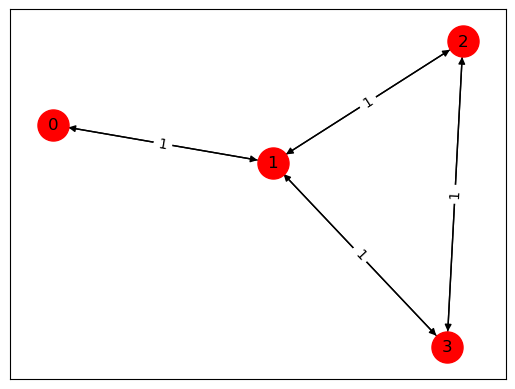

In [7]:
'''а) Создадим простой граф с 4 вершинами и 1 треугольником, в котором участвуют вершины 1, 2 и 3.'''
matrix1 = np.array([
    [0, 1, 0, 0],
    [1, 0, 1, 1],
    [0, 1, 0, 1],
    [0, 1, 1, 0]
])
M1 = gb.Matrix.from_dense(matrix1, missing_value=0)

gb.viz.draw(M1)

'''Проверка корректности результатов функций'''
assert naiveA3(M1) == 1
assert naiveMaskA2(M1) == 1
assert cohen(M1) == 1
assert sandia(M1) == 1
assert (countTriangles(M1) == np.array([0, 1, 1, 1])).all()

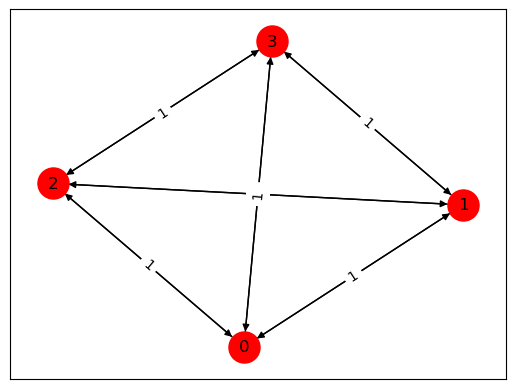

In [8]:
'''б) Создадим  граф с 4 вершинами, соединенными друг с другом полностью: в результате каждая вершина 
вляется вершиной 3 треугольников, а всего треугольников 4'''
matrix2 = np.array([
    [0, 1, 1, 1],
    [1, 0, 1, 1],
    [1, 1, 0, 1],
    [1, 1, 1, 0]
])
M2 = gb.Matrix.from_dense(matrix2, missing_value=0)

gb.viz.draw(M2)

'''Проверка корректности результатов функций'''
assert naiveA3(M2) == 4
assert naiveMaskA2(M2) == 4
assert cohen(M2) == 4
assert sandia(M2) == 4
assert (countTriangles(M2) == np.array([3, 3, 3, 3])).all()

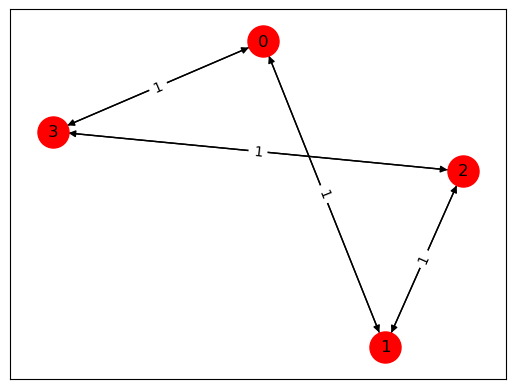

In [9]:
'''в) Создадим граф с 4 вершинами, соединенными друг с другом кольцом: в результате будет 0 треугольников'''
matrix3 = np.array([
    [0, 1, 0, 1],
    [1, 0, 1, 0],
    [0, 1, 0, 1],
    [1, 0, 1, 0]
])
M3 = gb.Matrix.from_dense(matrix3, missing_value=0)

gb.viz.draw(M3)

'''Проверка корректности результатов функций'''
assert naiveA3(M3) == 0
assert naiveMaskA2(M3) == 0
assert cohen(M3) == 0
assert sandia(M3) == 0
assert (countTriangles(M3) == np.array([0, 0, 0, 0])).all()

## 7) Оценка работы 10 графов

In [10]:
'''Тестирование результатов: сравнение значение + затраченного времени'''
def test(A):
    result = [naiveA3(A), naiveMaskA2(A), cohen(A), sandia(A)]
    print(result)
    if not all(result[0] == element for element in result):
        print("All return values are not equal")
    else:
        print('naiveA3:')
        %timeit naiveA3(A)
        print('naiveMaskA2:')
        %timeit naiveMaskA2(A)
        print('cohen:')
        %timeit cohen(A)
        print('sandia:')
        %timeit sandia(A)
        print('\n\n')

In [11]:
# Получить список файлов в папке data
files = os.listdir('data')
for file in files:
    M_i = mmread(f'data/{file}')
    print(f'Для {file} (кол-во вершин = {M_i.shape[0]}, кол-во рёбер = {len(M_i.to_coo()[0])}):')
    test(M_i)

Для auto.mtx (кол-во вершин = 448695, кол-во рёбер = 6629222):
[6245184, 6245184, 6245184, 6245184]
naiveA3:
7.64 s ± 2.04 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
naiveMaskA2:
1.09 s ± 162 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
cohen:
510 ms ± 78.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
sandia:
325 ms ± 39.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



Для fe_4elt2.mtx (кол-во вершин = 11143, кол-во рёбер = 65636):
[21681, 21681, 21681, 21681]
naiveA3:
11.4 ms ± 545 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
naiveMaskA2:
2.51 ms ± 110 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
cohen:
3.16 ms ± 120 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
sandia:
2.6 ms ± 75.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)



Для fe_body.mtx (кол-во вершин = 45087, кол-во рёбер = 327468):
[155176, 155176, 155176, 155176]
naiveA3:
62.3 ms ± 2.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops eac

### Вывод:
По результатам теста можно заключить следующее:
- Наивный алгоритм демонстрирует значительно худшие временные показатели, чем другие алгоритмы;
- Наивный алгоритм с маской работает намного быстрее обычного наивного алгоритма (в десятки раз) за счет того, что не требуется второй раз умножать большие матрицы.
- Что насчет алгоритмов Cohens и Sandia, они работают на порядок быстрее, при этом более эффективным оказался алгоритм Sandia.

## 8) Тестирование случайных графов

Была создана функция, которая на вход получает количество вершин и ребер и возвращает матрицу, сгенерированную из формата соо по спискам индексов и значений. 

**Алгоритм**: 
- Функция получает количество вершин и ребер;
- Случайно отбираются пары вершин из элементов выше диагонали матрицы смежности в количестве заданных ребер;
- Индексы выбранных вершин вместе с симметричными им (по причине того, что граф неориентированный) добавляются в списки;
- "Собирается" матрица из формата соо по спискам индексов и значений (для всех ребер вес выставлялся равным 1).

In [12]:
def generate_graph(num_vertices, num_edges):
    '''создание множества, состоящего из номеров ячеек верхнетреугольной матрицы (без диагональных элементов)'''
    high_positions=[]
    for ind in range(num_vertices**2):
        if ind // num_vertices < ind % num_vertices:
            high_positions.append(ind)

    '''Отбор num_edges случайных индексов вершин (случайные значения из high_positions) для создания ребер'''
    gen_indices = random.sample(high_positions, num_edges)
    
    '''Преобразование индексов в координаты (строка, столбец)'''
    row_indices, col_indices = np.unravel_index(gen_indices, (num_vertices, num_vertices))
    '''Добавление симметричных координат относительно диагонали матрицы'''
    indices_from = np.append(col_indices, row_indices)
    indices_to = np.append(row_indices, col_indices)
    
    return gb.Matrix.from_coo(indices_from, indices_to, [1]*len(indices_from), nrows=num_vertices, ncols=num_vertices)

### 8.1) Зависимость времени отработки алгоритмов от числа вершин графов при фикс числе рёбер (очень разреженные графы)

In [13]:
#как ведет себя время для очень разреженых графов с увеличением числа вершин
for i in range(1000, 10000, 1000):
    print(f'Количество вершин: {i}, количество ребер: 10')
    generated_graph = generate_graph(i, 10)
    test(generated_graph)

Количество вершин: 1000, количество ребер: 10
[0, 0, 0, 0]
naiveA3:
278 µs ± 17.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
naiveMaskA2:
213 µs ± 9.55 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
cohen:
428 µs ± 21.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
sandia:
389 µs ± 20.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)



Количество вершин: 2000, количество ребер: 10
[0, 0, 0, 0]
naiveA3:
261 µs ± 12.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
naiveMaskA2:
228 µs ± 23.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
cohen:
423 µs ± 19.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
sandia:
399 µs ± 32.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)



Количество вершин: 3000, количество ребер: 10
[0, 0, 0, 0]
naiveA3:
254 µs ± 13.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
naiveMaskA2:
213 µs ± 23.6 µs per loop (mean ± std. dev. of 7 runs, 1,000 loo

### Комментарии:

1. Наивный алгоритм почти всегда быстрее, чем Cohen и Sandia (т.к. те рассчитаны на более плотные графы с большим количеством вершин).
2. Наиболее эффективным по времени оказался наивный алгоритм с маской, оптимизирующий наивный алгоритм путем замены дорогой по времени операции умножения матриц на поэлементное умножение (использование маски).

Однако, на практике редко встречаются относительно малые и сильно разреженные графы, поэтому результаты теста трудно назвать значимыми для практического применения.

### 8.2) Зависимость времени отработки алгоритмов от плотности графа при фикс числе вершин 

In [15]:
#как ведет себя время для очень разреженых графов с увеличением числа вершин
for i in range(10000, 100000, 10000):
    print(f'Количество вершин: 1000, количество ребер: {i}')
    generated_graph = generate_graph(1000, i)
    test(generated_graph)

Количество вершин: 1000, количество ребер: 10000
[1374, 1374, 1374, 1374]
naiveA3:
20.7 ms ± 1.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
naiveMaskA2:
919 µs ± 40.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
cohen:
1.17 ms ± 88.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
sandia:
915 µs ± 65.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)



Количество вершин: 1000, количество ребер: 20000
[10665, 10665, 10665, 10665]
naiveA3:
21.7 ms ± 907 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
naiveMaskA2:
1.96 ms ± 43.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
cohen:
1.52 ms ± 46.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
sandia:
1.16 ms ± 49.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)



Количество вершин: 1000, количество ребер: 30000
[36054, 36054, 36054, 36054]
naiveA3:
32.6 ms ± 1.28 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
naiveMaskA2:
3.38 ms ± 158 

### Комментарии:
- С увеличением плотности графа наивный алгоритм начинает значительно уступать более оптимальным подходам.
- Наивный алгоритм с маской по-прежнему в среднем немного эффективнее классического наивного алгоритма;
- Наиболее эффективным алгоритмом оказался Sandia, т.к. он использует только верхний треугольник исходной матрицы смежности графа. Также алгоритм наиболее эффективен и с точки зрения используемой памяти.

В целом, можно заключить, что алгоритмы Sandia и Cohen's лучше всего использовать при решении задач, в которых графы являются достаточно плотными.

## Общие выводы:

 
Когда графы являются очень разреженными, лучше всего использовать наивный алгоритм или же свою модифицированную вариацию. В остальных же случаях более оптимальным (по времени и используемой памяти) являются алгоритмы Sandia и Cohen's с небольшим преимуществом первого.

